# Linear Regression with TensorFlow

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto (miles per galon) MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras tutorials and guides to learn more.)

```{contents}
:local:
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
print(tf.__version__)

2.17.0


## Dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

In [3]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]

raw_dataset = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

In [5]:
# The dataset contains a few unknown values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
# Drop those rows to keep this initial tutorial simple
dataset = dataset.dropna()

In [7]:
# One-hot encoding Origin column
dataset["Origin"] = dataset["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})

In [8]:
# The "Origin" column is categorical, not numeric.
# So the next step is to one-hot encode the values in the column with pd.get_dummies.
# https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

dataset = pd.get_dummies(dataset, columns=["Origin"], prefix="", prefix_sep="")
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


### Split the data into training and test sets

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

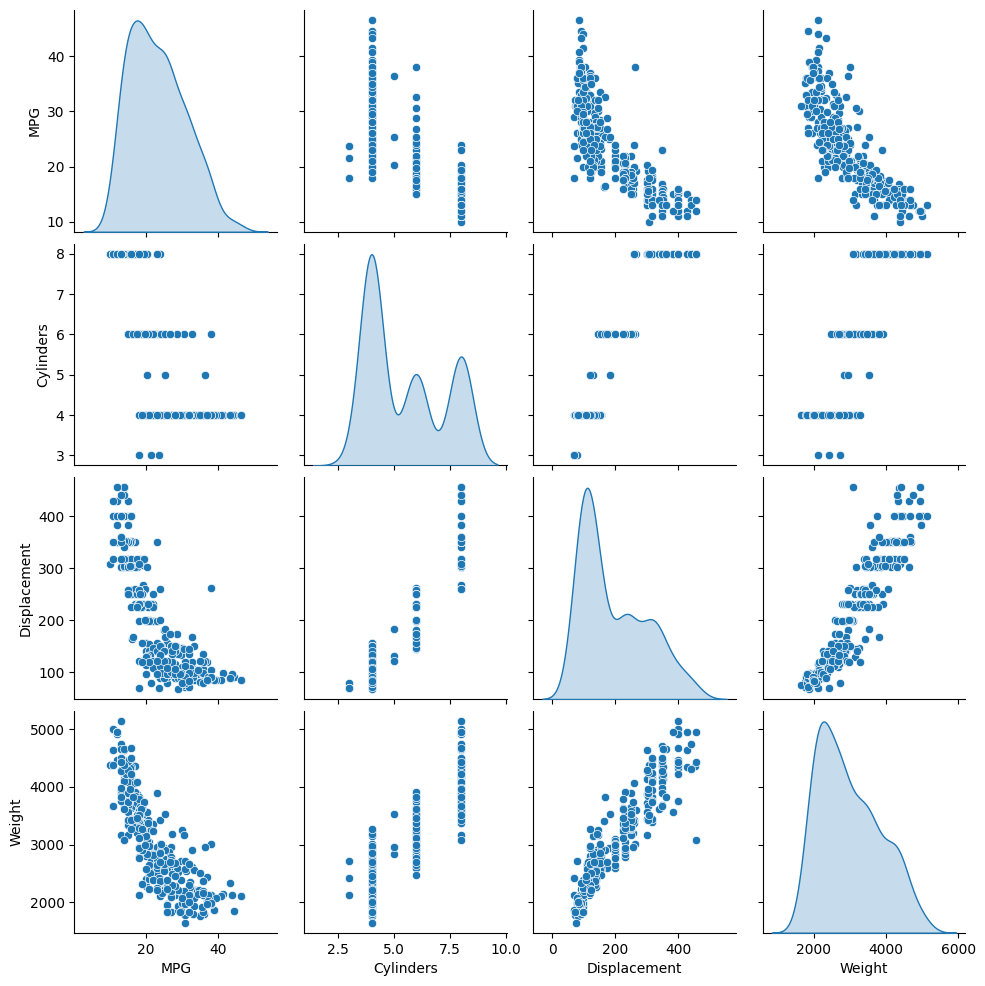

In [10]:
sns.pairplot(
    train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde"
)

In [11]:
# Let's also check the overall statistics. Note how each feature covers a very different range
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


### Split features from labels

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

In [13]:
train_dataset.describe().transpose()[["mean", "std"]]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [15]:
normalizer.adapt(np.array(train_features))

In [16]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print("First example:", first)
    print()
    print("Normalized:", normalizer(np.asarray(first).astype(np.float32)).numpy())

First example: [[4 90.0 75.0 2125.0 14.5 74 False False True]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

### Linear regression with one variable

Begin with a single-variable linear regression to predict 'MPG' from 'Horsepower'.

Training a model with tf.keras typically starts by defining the model architecture. Use a tf.keras.Sequential model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

* Normalize the 'Horsepower' input features using the tf.keras.layers.Normalization preprocessing layer.
* Apply a linear transformation (y = mx + b) to produce 1 output using a linear layer (tf.keras.layers.Dense).

The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

In [18]:
horsepower = np.array(train_features["Horsepower"])

horsepower_normalizer = layers.Normalization(
    input_shape=[
        1,
    ],
    axis=None,
)
horsepower_normalizer.adapt(horsepower)

/Users/ariefrahmansyah/Library/Caches/pypoetry/virtualenvs/applied-python-training-MLD32oJZ-py3.12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Build the Keras Sequential model
horsepower_model = tf.keras.Sequential([horsepower_normalizer, layers.Dense(units=1)])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [20]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[ 0.921],
       [ 0.52 ],
       [-1.7  ],
       [ 1.291],
       [ 1.168],
       [ 0.459],
       [ 1.384],
       [ 1.168],
       [ 0.304],
       [ 0.52 ]], dtype=float32)

In [21]:
# Once the model is built, configure the training procedure using the Keras Model.compile method.
# The most important arguments to compile are the loss and the optimizer,
# since these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).

horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)

In [22]:
%%time
history = horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2,
)

CPU times: user 1.99 s, sys: 236 ms, total: 2.23 s
Wall time: 1.99 s


In [23]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803140,4.193005,95
96,3.802998,4.194662,96
97,3.803431,4.190634,97
98,3.805895,4.208922,98
99,3.804925,4.192336,99


In [24]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.xlabel("Epoch")
    plt.ylabel("Error [MPG]")
    plt.legend()
    plt.grid(True)

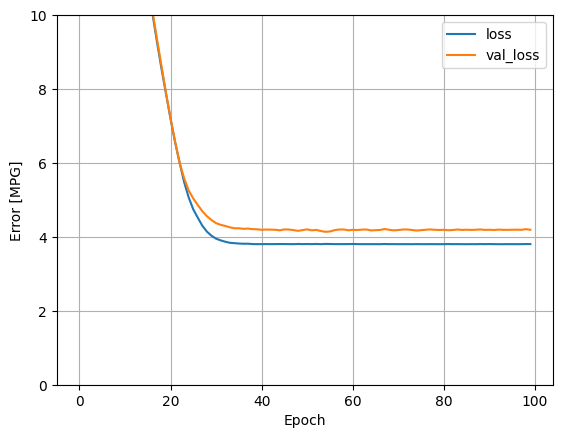

In [25]:
plot_loss(history)

In [26]:
# Collect the results on the test set for later
test_results = {}

test_results["horsepower_model"] = horsepower_model.evaluate(
    test_features["Horsepower"], test_labels, verbose=0
)

In [27]:
# Since this is a single variable regression, it's easy to view the model's predictions as a function of the input
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [28]:
def plot_horsepower(x, y):
    plt.scatter(train_features["Horsepower"], train_labels, label="Data")
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.legend()

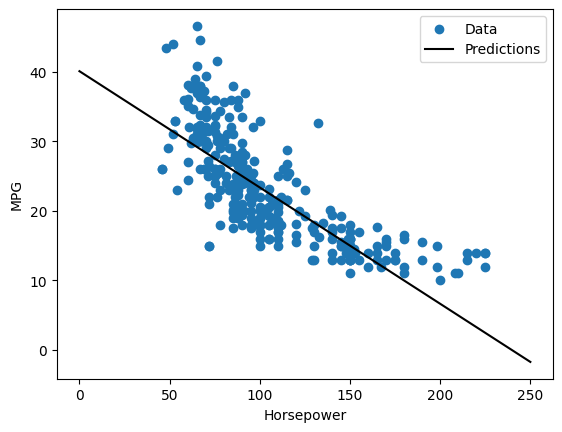

In [29]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same y = mx + b, except that m is a matrix and b is a vector.

Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)) you defined earlier and adapted to the whole dataset:

In [30]:
linear_model = tf.keras.Sequential([normalizer, layers.Dense(units=1)])

In [31]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[ 0.129],
       [ 0.144],
       [ 0.7  ],
       [-1.14 ],
       [ 0.208],
       [ 0.223],
       [ 0.356],
       [-0.496],
       [ 0.84 ],
       [ 1.644]], dtype=float32)

In [32]:
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_1/dense_1/kernel>

In [33]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)

In [34]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2,
)

CPU times: user 2.01 s, sys: 245 ms, total: 2.25 s
Wall time: 2.1 s


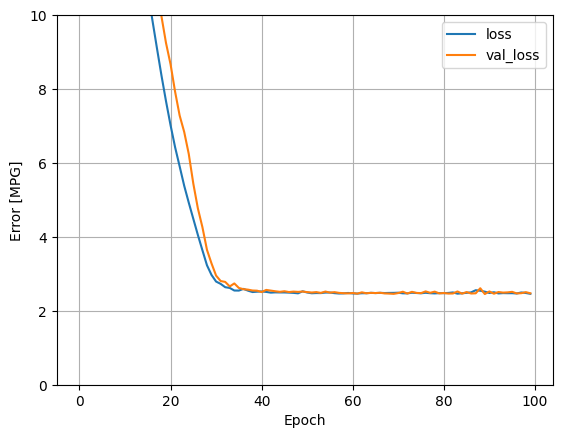

In [35]:
plot_loss(history)

In [36]:
test_results["linear_model"] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

## Regression with a deep neural network

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with horsepower_normalizer for a single-input model and normalizer for a multiple-input model).
* Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
* A linear Dense single-output layer.

In [37]:
def build_and_compile_model(norm):
    model = keras.Sequential(
        [
            norm,
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )

    model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001))
    return model

### Regression using a DNN and a single input

In [38]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [39]:
dnn_horsepower_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [40]:
%%time
history = dnn_horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100,
)

CPU times: user 2.2 s, sys: 259 ms, total: 2.46 s
Wall time: 2.18 s


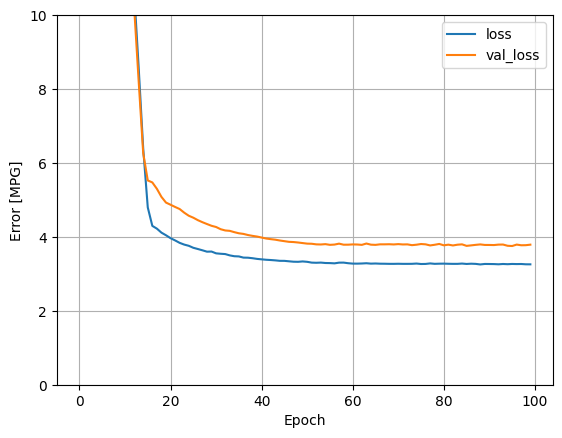

In [41]:
plot_loss(history)

In [42]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepWARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x302b19ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


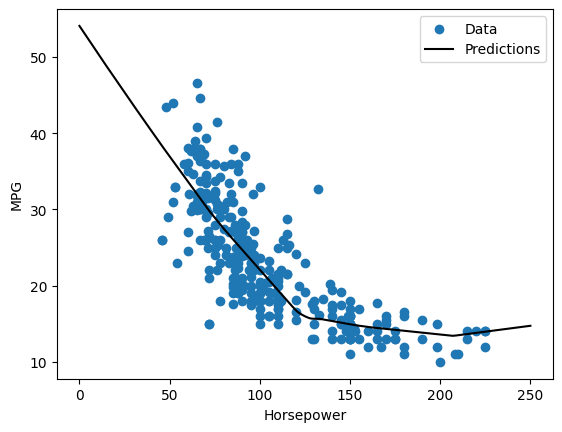

In [43]:
plot_horsepower(x, y)

In [44]:
test_results["dnn_horsepower_model"] = dnn_horsepower_model.evaluate(
    test_features["Horsepower"], test_labels, verbose=0
)

### Regression using a DNN and multiple inputs

In [45]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [46]:
%%time
history = dnn_model.fit(
    train_features, train_labels, validation_split=0.2, verbose=0, epochs=100
)

CPU times: user 2.2 s, sys: 253 ms, total: 2.45 s
Wall time: 2.17 s


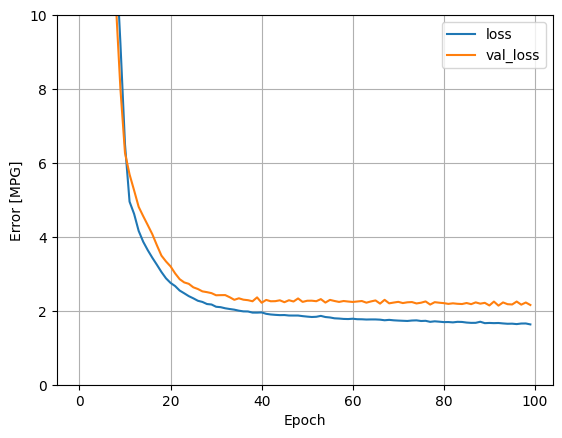

In [47]:
plot_loss(history)

In [48]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

In [49]:
pd.DataFrame(test_results, index=["Mean absolute error [MPG]"]).T

,Mean absolute error [MPG]
horsepower_model,3.653414
linear_model,2.462059
dnn_horsepower_model,2.895719
dnn_model,1.662322


### Make predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


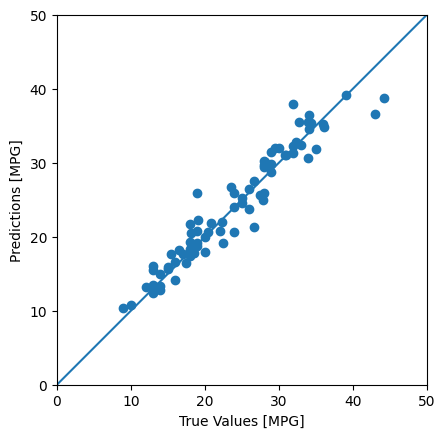

In [50]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect="equal")
plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

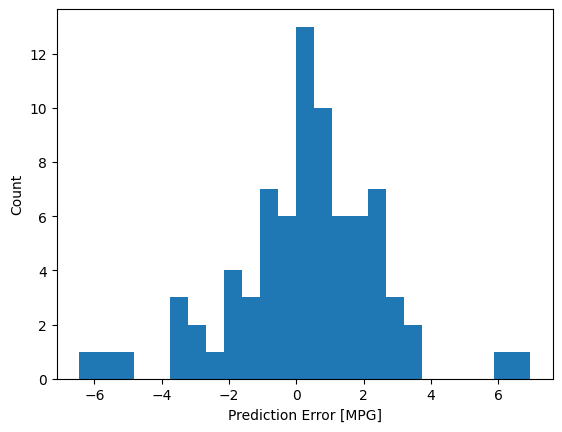

In [51]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")